In [1]:
import nltk   
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from wordcloud import WordCloud

import re
from itertools import chain
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')  
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
stopword = set(stopwords.words('english'))  

In [4]:
df=pd.read_csv('/content/data_set.csv')
df

,Unnamed: 0,comments
0,0,The following is a copy of the original post t...
1,1,>Do you think Black politics are treated as ra...
2,2,"Yes. We treat white, male, CIS, heterosexual, ..."
3,3,Any politics that acknowledges America's histo...
4,4,Gonna throw this out there: \n\n1) White natio...
...,...,...
106,106,You’ll note this thread started cause someone ...
107,107,Liberals love to tell oppressed people to ask ...
108,108,That’s not enough. We will continue to press f...
109,109,Institutions which you support. You already ma...


In [5]:
# sentiment analysis
sentiment =  SentimentIntensityAnalyzer()
sentiment_data = [*df['comments'].apply(sentiment.polarity_scores)]
sentiment_data

[{'compound': 0.5574, 'neg': 0.0, 'neu': 0.932, 'pos': 0.068},
 {'compound': -0.0772, 'neg': 0.094, 'neu': 0.815, 'pos': 0.091},
 {'compound': 0.6597, 'neg': 0.0, 'neu': 0.735, 'pos': 0.265},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0772, 'neg': 0.045, 'neu': 0.904, 'pos': 0.051},
 {'compound': -0.802, 'neg': 0.163, 'neu': 0.837, 'pos': 0.0},
 {'compound': 0.1593, 'neg': 0.044, 'neu': 0.887, 'pos': 0.069},
 {'compound': 0.2023, 'neg': 0.091, 'neu': 0.799, 'pos': 0.11},
 {'compound': 0.0258, 'neg': 0.089, 'neu': 0.818, 'pos': 0.093},
 {'compound': 0.6582, 'neg': 0.037, 'neu': 0.908, 'pos': 0.055},
 {'compound': 0.4019, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'compound': -0.9661, 'neg': 0.151, 'neu': 0.805, 'pos': 0.045},
 {'compound': -0.4391, 'neg': 0.126, 'neu': 0.782, 'pos': 0.092},
 {'compound': 0.7343, 'neg': 0.0, 'neu': 0.857, 'pos': 0.143},
 {'compound': 0.9633, 'neg': 0.032, 'neu': 0.662, 'pos': 0.306},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'po

In [6]:
# convert it into dataframe
sentiment_df = pd.DataFrame.from_records(sentiment_data)
sentiment_df = pd.concat([df, sentiment_df], axis=1, join='inner')
sentiment_df.describe()

,Unnamed: 0,neg,neu,pos,compound
count,111.000000,111.000000,111.000000,111.000000,111.000000
mean,55.000000,0.110766,0.781820,0.107477,-0.116806
std,32.186954,0.113834,0.153023,0.129748,0.628635
min,0.000000,0.000000,0.000000,0.000000,-0.996800
25%,27.500000,0.000000,0.705000,0.000000,-0.746550
50%,55.000000,0.089000,0.785000,0.089000,0.000000
75%,82.500000,0.176500,0.877000,0.151500,0.401900
max,110.000000,0.545000,1.000000,1.000000,0.990000


(-2.0, 2.0)

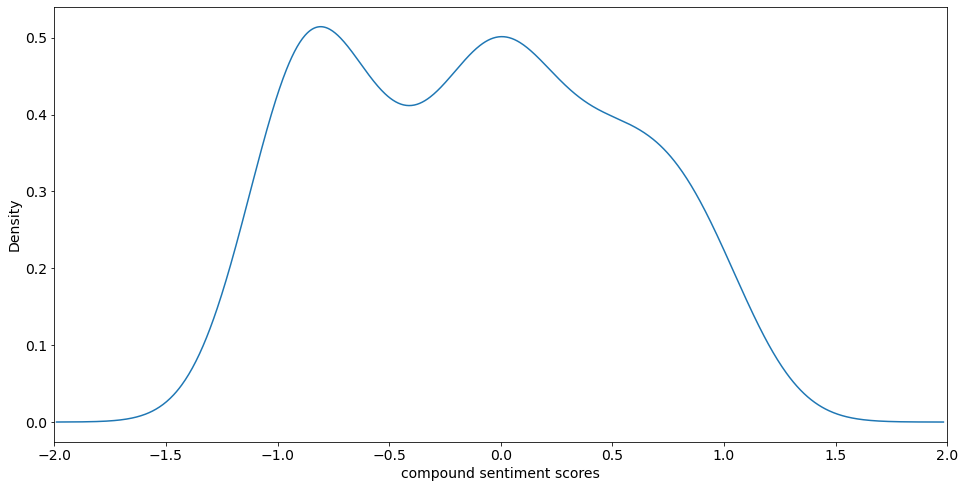

In [7]:
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 14})
sentiment_df['compound'].plot.density(label='Sentiment density')
plt.xlabel('compound sentiment scores')
plt.xlim(-2,2)

As we can see, the sentiment density plot has 2 peaks at -1.0 and 0.0. This plot shows that most of the comments on the post has negative or neutral sentiments  

In [8]:
# We labelled the comments on the  basis of sentiments they express for further clarification  
sentiment_df['label'] = 0   # Neutral
sentiment_df.loc[sentiment_df['compound'] >= 0.05, 'label'] = 1 # Positive
sentiment_df.loc[sentiment_df['compound'] <= -0.05, 'label'] = -1   # Negative

In [9]:
sentiment_df.label.value_counts()

-1    53
 1    40
 0    18
Name: label, dtype: int64

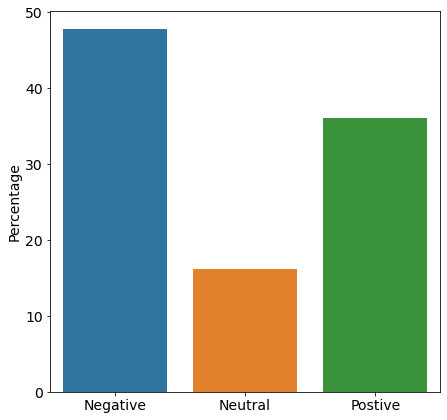

In [10]:
figure, axis = plt.subplots(figsize=(7, 7))
counts = sentiment_df.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=axis)
axis.set_xticklabels(['Negative', 'Neutral', 'Postive'])
axis.set_ylabel("Percentage")
plt.show()

From above graph, we can see that the percentage of comments with negative sentiment on post is more than the positive and the neutral comments are least. We conclude that the  peak at 0.0 in sentiment density plot is not perfect at 0.

#Pre-processing 

In [11]:
def preprocess(comment):
    preprocess_comment = comment
    preprocess_comment = preprocess_comment.lower()
    preprocess_comment = re.sub(r'\n|[^a-zA-Z]', ' ', preprocess_comment)
    preprocess_comment = ' '.join(word for word in preprocess_comment.split() if word not in stopword)
    return preprocess_comment

sentiment_df['Processed_Comment'] = sentiment_df['comments'].apply(lambda x: preprocess(x)) 

In [12]:
sentiment_df['Processed_Comment'] = sentiment_df['Processed_Comment'].apply(word_tokenize) #tokenization
# lemmetization
lemmatizer = WordNetLemmatizer()
sentiment_df['lemmatize_Comment'] = sentiment_df['Processed_Comment'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
sentiment_df.head(5)

,Unnamed: 0,comments,neg,neu,pos,compound,label,Processed_Comment,lemmatize_Comment
0,0,The following is a copy of the original post t...,0.000,0.932,0.068,0.5574,1,"[following, copy, original, post, record, post...","[following, copy, original, post, record, post..."
1,1,>Do you think Black politics are treated as ra...,0.094,0.815,0.091,-0.0772,-1,"[think, black, politics, treated, radical, pol...","[think, black, politics, treated, radical, pol..."
2,2,"Yes. We treat white, male, CIS, heterosexual, ...",0.000,0.735,0.265,0.6597,1,"[yes, treat, white, male, cis, heterosexual, n...","[yes, treat, white, male, ci, heterosexual, no..."
3,3,Any politics that acknowledges America's histo...,0.000,1.000,0.000,0.0000,0,"[politics, acknowledges, america, historic, on...","[politics, acknowledges, america, historic, on..."
4,4,Gonna throw this out there: \n\n1) White natio...,0.045,0.904,0.051,0.0772,1,"[gon, na, throw, white, nationalist, groups, a...","[gon, na, throw, white, nationalist, group, ab..."


#Word Count

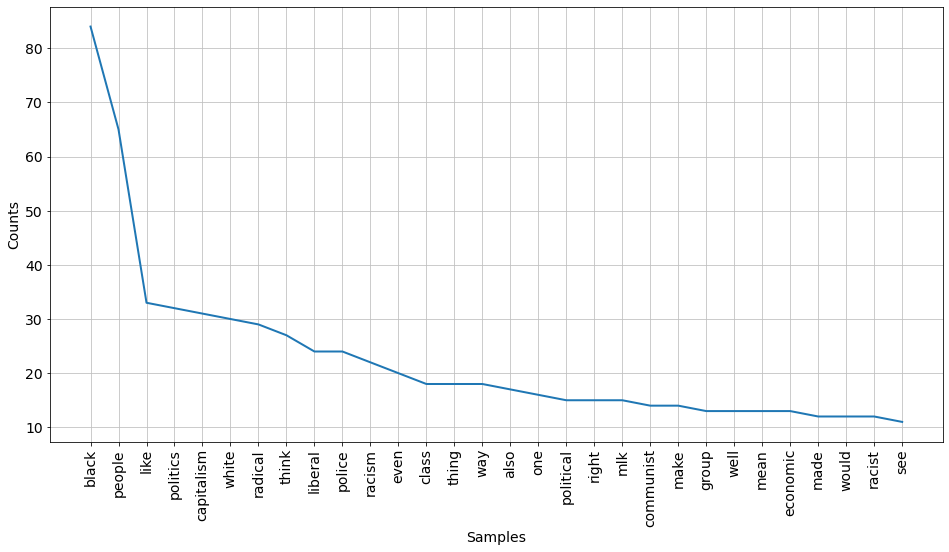

FreqDist({'following': 1,
          'copy': 1,
          'original': 1,
          'post': 4,
          'record': 1,
          'originally': 1,
          'written': 2,
          'new': 2,
          'piece': 2,
          'tnr': 1,
          'stigma': 2,
          'black': 84,
          'political': 15,
          'activism': 5,
          'wanted': 2,
          'see': 11,
          'take': 10,
          'liberal': 24,
          'http': 6,
          'newrepublic': 2,
          'com': 5,
          'article': 7,
          'myth': 2,
          'radical': 29,
          'politics': 32,
          'stymy': 2,
          'progressive': 5,
          'bot': 1,
          'action': 3,
          'performed': 1,
          'automatically': 1,
          'please': 1,
          'contact': 1,
          'moderator': 1,
          'subreddit': 1,
          'message': 4,
          'compose': 1,
          'r': 1,
          'askaliberal': 1,
          'question': 11,
          'concern': 1,
          'think': 27,
  

In [13]:
# frequency of words
word = sentiment_df['lemmatize_Comment'].apply(pd.Series).stack()
freqdist = FreqDist(word)
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 14})
freqdist.plot(30, cumulative=False)
freqdist

In [14]:
# visualization using wordcloud for the negative sentiment comments
negative_df=sentiment_df[sentiment_df['label']==-1]
word_list = list(chain.from_iterable(negative_df.Processed_Comment.values))
words = ' '.join(word_list)

In [15]:
wordcloud = WordCloud(background_color='black').generate(words)

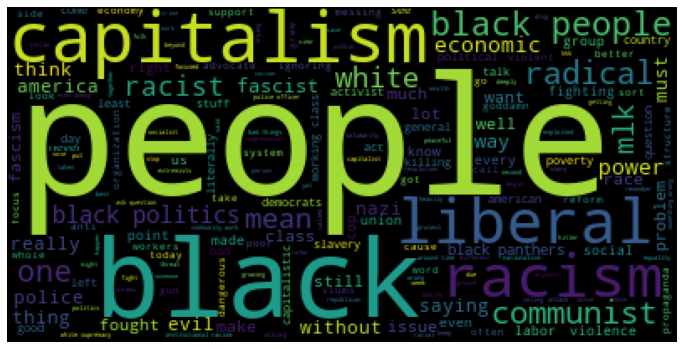

In [16]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
# visualization using wordcloud for the positive sentiment comments
positive_df=sentiment_df[sentiment_df['label']==1]
word_list = list(chain.from_iterable(positive_df.Processed_Comment.values))
words = ' '.join(word_list)


In [18]:
wordcloud = WordCloud(background_color='black').generate(words)

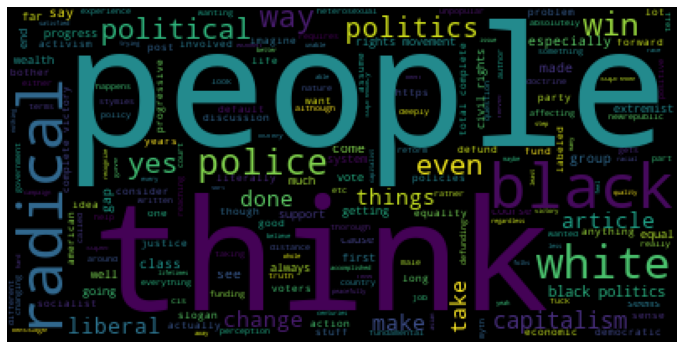

In [19]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
# visualization using wordcloud for the neutral sentiment comments
neutral_df=sentiment_df[sentiment_df['label']==0]
word_list = list(chain.from_iterable(neutral_df.Processed_Comment.values))
words = ' '.join(word_list)

In [21]:
wordcloud = WordCloud(background_color='black').generate(words)

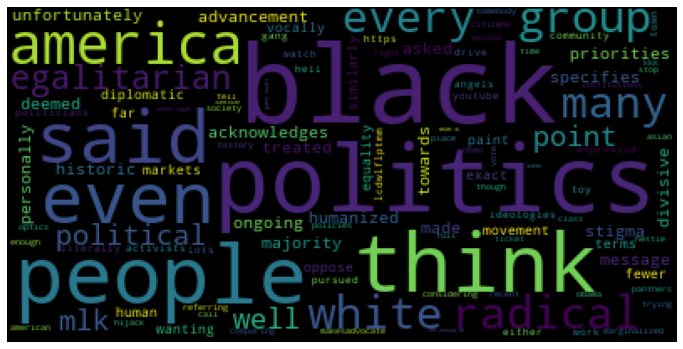

In [22]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Bi-grams 

Bi-gram analysis is referred from here https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

In [23]:
from nltk import bigrams

import networkx as nx

import itertools
import collections

In [24]:
# Create list of lists containing bigrams in comments
terms_bigram = [list(bigrams(comment)) for comment in sentiment_df['Processed_Comment']]

# View bigrams for the first comment
terms_bigram[0]

[('following', 'copy'),
 ('copy', 'original'),
 ('original', 'post'),
 ('post', 'record'),
 ('record', 'post'),
 ('post', 'originally'),
 ('originally', 'written'),
 ('written', 'new'),
 ('new', 'piece'),
 ('piece', 'tnr'),
 ('tnr', 'stigma'),
 ('stigma', 'black'),
 ('black', 'political'),
 ('political', 'activism'),
 ('activism', 'wanted'),
 ('wanted', 'see'),
 ('see', 'take'),
 ('take', 'liberals'),
 ('liberals', 'https'),
 ('https', 'newrepublic'),
 ('newrepublic', 'com'),
 ('com', 'article'),
 ('article', 'myth'),
 ('myth', 'radical'),
 ('radical', 'black'),
 ('black', 'politics'),
 ('politics', 'stymies'),
 ('stymies', 'progressive'),
 ('progressive', 'politics'),
 ('politics', 'https'),
 ('https', 'newrepublic'),
 ('newrepublic', 'com'),
 ('com', 'article'),
 ('article', 'myth'),
 ('myth', 'radical'),
 ('radical', 'black'),
 ('black', 'politics'),
 ('politics', 'stymies'),
 ('stymies', 'progressive'),
 ('progressive', 'politics'),
 ('politics', 'bot'),
 ('bot', 'action'),
 ('acti

In [25]:
# Flatten list of bigrams in clean comments
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

In [26]:
bigram_counts.most_common(20)

[(('black', 'people'), 21),
 (('black', 'politics'), 20),
 (('black', 'panthers'), 9),
 (('white', 'supremacy'), 6),
 (('working', 'class'), 6),
 (('community', 'work'), 6),
 (('can', 'not'), 5),
 (('defund', 'police'), 5),
 (('institutional', 'racism'), 5),
 (('civil', 'rights'), 5),
 (('radical', 'black'), 4),
 (('especially', 'black'), 4),
 (('seems', 'like'), 4),
 (('bad', 'things'), 4),
 (('wealth', 'gap'), 4),
 (('rights', 'movement'), 4),
 (('black', 'political'), 3),
 (('white', 'men'), 3),
 (('police', 'radical'), 3),
 (('labeled', 'radical'), 3)]

In [27]:
# dataframe contains bigram counts
bigram_df = pd.DataFrame(bigram_counts.most_common(20),columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(black, people)",21
1,"(black, politics)",20
2,"(black, panthers)",9
3,"(white, supremacy)",6
4,"(working, class)",6
5,"(community, work)",6
6,"(can, not)",5
7,"(defund, police)",5
8,"(institutional, racism)",5
9,"(civil, rights)",5


Now we will use this dataframe  to visualize the top 20 occurring bigrams.

In [28]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

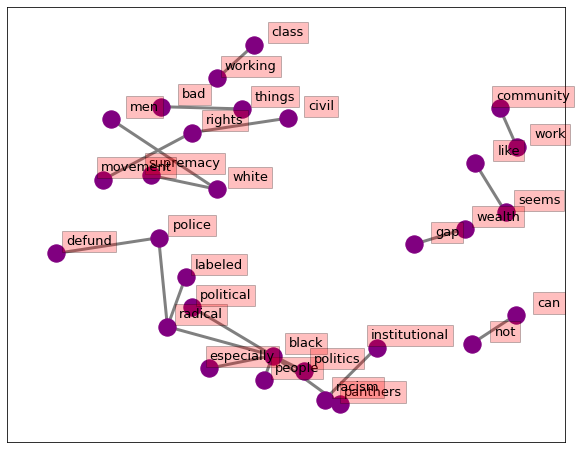

In [29]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

#Topic Modelling

Reference for topic modelling :
  https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [30]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [31]:
words = list(sentiment_df['Processed_Comment']) #convert into list 

In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [33]:
# See trigram example
trigram_mod[bigram_mod[words[5]][:3]]

['absolutely', 'pick', 'guns']

In [34]:
# make bigrams and trigrams
def make_bigrams(words):
    return [bigram_mod[word] for word in words]

def make_trigrams(words):
    return [trigram_mod[bigram_mod[word]] for word in words]

In [35]:
# Form Bigrams
data_words_bigrams = make_bigrams(words)

In [36]:
# lemmetization of comments with bi-gram model
lemmatizer = WordNetLemmatizer()
comment_lemmatized  = []

for sentence in data_words_bigrams:
  text=[]
  for word in sentence:
    text.append(lemmatizer.lemmatize(word))
  comment_lemmatized.append(text)

comment_lemmatized[:5]

[['following',
  'copy',
  'original',
  'post',
  'record',
  'post',
  'originally',
  'written',
  'new',
  'piece',
  'tnr',
  'stigma',
  'black',
  'political',
  'activism',
  'wanted',
  'see',
  'take',
  'liberal',
  'http',
  'newrepublic',
  'com',
  'article',
  'myth',
  'radical',
  'black',
  'politics',
  'stymy',
  'progressive',
  'politics',
  'http',
  'newrepublic',
  'com',
  'article',
  'myth',
  'radical',
  'black',
  'politics',
  'stymy',
  'progressive',
  'politics',
  'bot',
  'action',
  'performed',
  'automatically',
  'please',
  'contact',
  'moderator',
  'subreddit',
  'message',
  'compose',
  'r',
  'askaliberal',
  'question',
  'concern'],
 ['think',
  'black',
  'politics',
  'treated',
  'radical',
  'politics',
  'yes',
  'common',
  'old',
  'tactic',
  'paint',
  'black',
  'political',
  'activist',
  'extreme',
  'also',
  'ignoring',
  'substance',
  'say',
  'acknowledge',
  'demand',
  'martin',
  'luther',
  'king',
  'jr',
  'movem

In [37]:
# Create Dictionary to build LDA model
id2word = corpora.Dictionary(comment_lemmatized)

# Create Corpus
texts = comment_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 3), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 2), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [38]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('action', 1),
  ('activism', 1),
  ('article', 2),
  ('askaliberal', 1),
  ('automatically', 1),
  ('black', 3),
  ('bot', 1),
  ('com', 2),
  ('compose', 1),
  ('concern', 1),
  ('contact', 1),
  ('copy', 1),
  ('following', 1),
  ('http', 2),
  ('liberal', 1),
  ('message', 1),
  ('moderator', 1),
  ('myth', 2),
  ('new', 1),
  ('newrepublic', 2),
  ('original', 1),
  ('originally', 1),
  ('performed', 1),
  ('piece', 1),
  ('please', 1),
  ('political', 1),
  ('politics', 4),
  ('post', 2),
  ('progressive', 2),
  ('question', 1),
  ('r', 1),
  ('radical', 2),
  ('record', 1),
  ('see', 1),
  ('stigma', 1),
  ('stymy', 2),
  ('subreddit', 1),
  ('take', 1),
  ('tnr', 1),
  ('wanted', 1),
  ('written', 1)]]

In [39]:
#Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,  # take number of topics reference as 10.
                                           random_state=100,
                                           update_every=1,   
                                           alpha='auto',    
                                           per_word_topics=True)

In [40]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"people" + 0.028*"black" + 0.019*"like" + 0.013*"think" + '
  '0.011*"white" + 0.009*"police" + 0.007*"well" + 0.007*"thing" + '
  '0.007*"politics" + 0.006*"radical"'),
 (1,
  '0.017*"police" + 0.012*"people" + 0.010*"thing" + 0.008*"slogan" + '
  '0.007*"fund" + 0.007*"bumper" + 0.007*"sticker" + 0.007*"propaganda" + '
  '0.006*"even" + 0.006*"way"'),
 (2,
  '0.044*"black" + 0.017*"people" + 0.017*"politics" + 0.010*"white" + '
  '0.009*"radical" + 0.007*"issue" + 0.007*"reform" + 0.006*"activist" + '
  '0.006*"like" + 0.005*"advocate"'),
 (3,
  '0.013*"economic" + 0.012*"capitalism" + 0.009*"fought" + 0.009*"really" + '
  '0.009*"think" + 0.009*"without" + 0.008*"mean" + 0.008*"messing" + '
  '0.008*"talk" + 0.008*"slum"'),
 (4,
  '0.014*"capitalism" + 0.013*"racism" + 0.012*"power" + 0.012*"mlk" + '
  '0.010*"also" + 0.008*"much" + 0.008*"right" + 0.008*"race" + '
  '0.008*"economic" + 0.008*"working_class"'),
 (5,
  '0.014*"black" + 0.009*"liberal" + 0.009*"get" + 0.

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=comment_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.83640184734094

Coherence Score:  0.3360548605497654


In [42]:
! pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5b7c0d70008725b2d41ab79d04bb11c772ed285bf4788553c2ad2bc7ae2a2ca1
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis


In [43]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
visual

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.014470 -0.074062       1        1  16.488437
9      0.105384  0.061455       2        1  12.316651
6      0.030460  0.019974       3        1  11.965206
8     -0.070774 -0.055568       4        1  11.630859
2      0.014055 -0.105072       5        1  10.913386
4     -0.068005  0.085897       6        1   9.589957
3     -0.094555  0.033369       7        1   8.448849
1      0.050096  0.023120       8        1   8.062806
7     -0.014822  0.020562       9        1   5.397697
5      0.033691 -0.009675      10        1   5.186153, topic_info=             Term       Freq      Total Category  logprob  loglift
5           black  60.000000  60.000000  Default  30.0000  30.0000
46      communist  10.000000  10.000000  Default  29.0000  29.0000
14        liberal  16.000000  16.000000  Default  28.0000  28.0000
26       politics  22.000000  22.000000  Default  27.0000  27.0000
169        people  48.000000  48.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
354       violent   0.652327   3.443672  Topic10  -5.5907   1.2954
94     absolutely   0.649600   3.793395  Topic10  -5.5949   1.1945
126  organization   0.643954   4.263580  Topic10  -5.6036   1.0689
119    government   0.631505   3.649300  Topic10  -5.6231   1.2050
696           bad   0.647133   7.442194  Topic10  -5.5987   0.5168

[653 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
642       4  0.775475    abolishing
94        3  0.263616    absolutely
94        6  0.263616    absolutely
94       10  0.263616    absolutely
1244      7  0.825993  accomplished
...     ...       ...           ...
69        8  0.137950           yes
69        9  0.137950           yes
69       10  0.137950           yes
856       9  0.815540          york
798       5  0.701065       youtube

[1022 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 7, 9, 3, 5, 4, 2, 8, 6])

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

**Compute better model which has optimal number of topics **

In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  gensim.models.ldamodel.LdaModel( corpus=corpus, id2word=id2word,num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# May take a long time to run if we have more number of models.
#Here I have taken the 2 number of topics to 10 number of topics in consideration 
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=comment_lemmatized, start=2, limit=11, step=1)

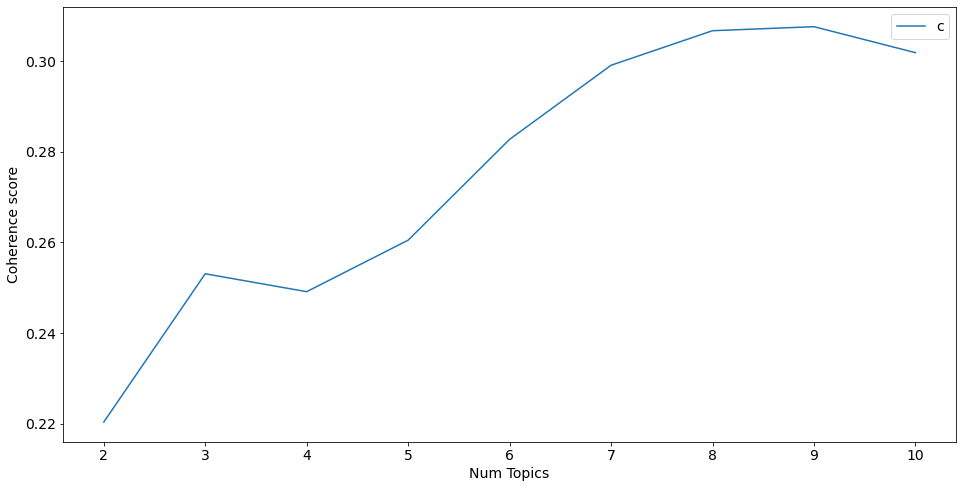

In [47]:
# Show graph of coherence values
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In graph, we can observe that the coherence value of model with 9 number of topics is higher . 

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2203
Num Topics = 3  has Coherence Value of 0.253
Num Topics = 4  has Coherence Value of 0.2491
Num Topics = 5  has Coherence Value of 0.2605
Num Topics = 6  has Coherence Value of 0.2827
Num Topics = 7  has Coherence Value of 0.2991
Num Topics = 8  has Coherence Value of 0.3067
Num Topics = 9  has Coherence Value of 0.3076
Num Topics = 10  has Coherence Value of 0.3018


we can confirm from here also that the coherence value of model 7 is high. 

In [49]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"people" + 0.012*"black" + 0.011*"liberal" + 0.011*"police" + '
  '0.009*"one" + 0.007*"much" + 0.007*"communist" + 0.006*"issue" + '
  '0.005*"like" + 0.005*"vote"'),
 (1,
  '0.036*"black" + 0.012*"mlk" + 0.011*"people" + 0.009*"race" + 0.009*"think" '
  '+ 0.007*"goddamn" + 0.007*"capitalism" + 0.007*"class" + 0.007*"fought" + '
  '0.006*"panther"'),
 (2,
  '0.021*"black" + 0.018*"politics" + 0.009*"http" + 0.008*"people" + '
  '0.008*"radical" + 0.008*"capitalism" + 0.007*"white" + 0.007*"com" + '
  '0.006*"racist" + 0.006*"even"'),
 (3,
  '0.020*"people" + 0.016*"black" + 0.009*"white" + 0.009*"politics" + '
  '0.008*"think" + 0.007*"call" + 0.007*"police" + 0.007*"want" + 0.007*"many" '
  '+ 0.006*"also"'),
 (4,
  '0.010*"people" + 0.010*"focused" + 0.009*"class" + 0.007*"capitalism" + '
  '0.007*"poverty" + 0.007*"policy" + 0.006*"white" + 0.006*"question" + '
  '0.006*"must" + 0.005*"also"'),
 (5,
  '0.013*"black" + 0.013*"politics" + 0.010*"radical" + 0.010*"even"

**Dominant Topic** 

In [50]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each comment
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage Contribution and Keywords for each comment
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percent_Contri', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Percent_Contri,Keywords,Text
0,0,2.0,0.9841,"black, politics, http, people, radical, capita...","[following, copy, original, post, record, post..."
1,1,5.0,0.9760,"black, politics, radical, even, like, communis...","[think, black, politics, treated, radical, pol..."
2,2,8.0,0.9365,"people, black, racism, white, capitalism, even...","[yes, treat, white, male, cis, heterosexual, n..."
3,3,5.0,0.9613,"black, politics, radical, even, like, communis...","[politics, acknowledges, america, historic, on..."
4,4,3.0,0.9671,"people, black, white, politics, think, call, p...","[gon, na, throw, white, nationalist, groups, a..."
5,5,3.0,0.9613,"people, black, white, politics, think, call, p...","[absolutely, pick, guns, form, militia, labele..."
6,6,3.0,0.9826,"people, black, white, politics, think, call, p...","[whether, something, political, extreme, defin..."
7,7,8.0,0.9658,"people, black, racism, white, capitalism, even...","[yes, applies, indigenous, people, us, disrupt..."
8,8,8.0,0.9407,"people, black, racism, white, capitalism, even...","[unfortunately, think, every, black, people, t..."
9,9,6.0,0.8079,"capitalism, white, radical, like, group, polic...","[half, way, article, beginning, seems, reasona..."


In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Percent_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Percent_Contri", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Percent_Contri,Keywords,Text
0,0.0,0.9889,"people, black, liberal, police, one, much, com...","[lot, liberals, incapable, effectively, fighti..."
1,1.0,0.9826,"black, mlk, people, race, think, goddamn, capi...","[mlk, socialist, stop, trying, hijack, cause, ..."
2,2.0,0.9841,"black, politics, http, people, radical, capita...","[following, copy, original, post, record, post..."
3,3.0,0.9936,"people, black, white, politics, think, call, p...","[absolutely, look, post, mortem, george, floyd..."
4,4.0,0.9658,"people, focused, class, capitalism, poverty, p...","[wrong, focused, heavily, race, cause, people,..."


In [52]:

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"black, politics, http, people, radical, capita...",15.0,0.1351
1.0,5.0,"black, politics, radical, even, like, communis...",13.0,0.1171
2.0,8.0,"people, black, racism, white, capitalism, even...",8.0,0.0721
3.0,5.0,"black, politics, radical, even, like, communis...",15.0,0.1351
4.0,3.0,"people, black, white, politics, think, call, p...",6.0,0.0541
...,...,...,...,...
106.0,7.0,"black, people, like, radical, politics, think,...",NaN,NaN
107.0,5.0,"black, politics, radical, even, like, communis...",NaN,NaN
108.0,2.0,"black, politics, http, people, radical, capita...",NaN,NaN
109.0,0.0,"people, black, liberal, police, one, much, com...",NaN,NaN
